# ML Training in SageMaker

The model used for this notebook is a basic Convolutional Neural Network (CNN).  
We'll train the CNN to classify images using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), a well-known computer vision dataset.

![cifar10](https://maet3608.github.io/nuts-ml/_images/cifar10.png)

## 데모 순서
아래의 순서로 학습을 실행할 예정입니다.
1. 개발 환경 구축
2. Input Data 준비
3. SOTA 코드 수정하기 (input data, output model)
4. Development 환경에서 학습 정상 동작여부 확인
5. Training job으로 던지기
6. 학습 모니터링 (상태 확인, 로그 확인 etc)
7. 저장된 모델 확인
8. Deploy model

## 1. Build development environment

데모를 수행할 개발 환경으로 SageMaker studio를 사용하겠다

- Sagemaker Studio is an extension of Jupyter Lab
- SageMaker Studio is an ML development environment that can easily use the Sagemaker features
- To load the notebook kernel, computing instances must be launched

Training script for demo is based on `Pytorch` framework.
So, before start the demo, we have to set the instance spec and kernel gateway image.
- instance spec: ml.g4dn.xlarge (4vCPU + 16GB + 1GPU)
- kernel image: PyTorch 1.6 Python 3.6 GPU Optimized

## 2. Input Data 준비

In [ ]:
from get_cifar10 import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

[2021-06-23 08:18:33.080 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-ea4e8aa54785f58297ce8b1c9f8b:1016 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-06-23 08:18:33.116 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-ea4e8aa54785f58297ce8b1c9f8b:1016 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
      dog     horse       dog       cat


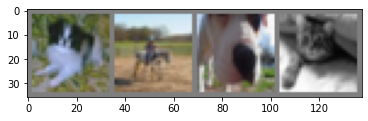

In [2]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(" ".join("%9s" % classes[labels[j]] for j in range(4)))

In [3]:
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

inputs = sagemaker_session.upload_data(path="data", 
                                       bucket=sagemaker_session.default_bucket(), 
                                       key_prefix="data/cifar10")

print(inputs)

s3://sagemaker-ap-northeast-2-834160605896/data/cifar10


## 2. Modify SOTA code

sagemaker를 통해 생성된 trainig job이 우리가 지정한 input data를 받도록 하고, 생성된 모델을 관리하도록 하기 위해서  
We have to set input data path and output model path using environment variable.

This is SageMake [Environment variables guide](https://github.com/aws/sagemaker-training-toolkit/blob/master/ENVIRONMENT_VARIABLES.md).

In [4]:
!diff source/train.py source/train_sagemaker.py

15a16,20
> try:
>     from sagemaker_inference import environment
> except:
>     from sagemaker_training import environment
> 
117,118c122,124
<     parser.add_argument("--model-dir", type=str, default='./model')
<     parser.add_argument("--data-dir", type=str, default='./data')
---
>     env = environment.Environment()
>     parser.add_argument("--model-dir", type=str, default=env.model_dir)
>     parser.add_argument("--data-dir", type=str, default=env.channel_input_dirs.get("training"))


## 3. Development 환경에서 학습 정상 동작여부 확인

SOTA 코드 수정을 완료하였으면, 실제로 해당 코드가 정상적으로 작동하는 지 확인해보아야 한다.  
epoch을 1로 설정하여 job을 던진다.

사용자의 local 환경에서도 테스트를 돌려볼 수 있다.  
To train in Local Mode, it is necessary to have `docker-compose` or `nvidia-docker-compose` (for GPU) installed in the notebook instance.

In [5]:
from sagemaker.pytorch.estimator import PyTorch

instance_type = 'ml.p2.xlarge'

pytorch_estimator = PyTorch(
    source_dir='source',
    entry_point='train_sagemaker.py',
    framework_version="1.7.1",
    py_version='py3',
    role=sagemaker.get_execution_role(),
    base_job_name='0623-cifar10-test2222',
    instance_count=1,
    instance_type=instance_type,
    hyperparameters = {'epochs': 1, 'lr': 0.01, 'batch': 64},
    metric_definitions=[
        {'Name': 'accuracy', 'Regex': 'Test Accuracy: (.*?);'}
    ]
)

In [6]:
pytorch_estimator.fit(inputs, logs=False)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: 0623-cifar10-test2222-2021-06-23-08-18-50-394



2021-06-23 08:18:50 Starting - Starting the training job
2021-06-23 08:18:52 Starting - Launching requested ML instances............
2021-06-23 08:19:58 Starting - Preparing the instances for training...................
2021-06-23 08:21:39 Downloading - Downloading input data.........
2021-06-23 08:22:30 Training - Downloading the training image........................................
2021-06-23 08:25:57 Training - Training image download completed. Training in progress.......
2021-06-23 08:26:33 Uploading - Uploading generated training model
2021-06-23 08:26:33 Failed - Training job failed


UnexpectedStatusException: Error for Training job 0623-cifar10-test2222-2021-06-23-08-18-50-394: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python3.6 train_sagemaker.py --batch 64 --epochs 1 --lr 0.01"
Traceback (most recent call last):
  File "train_sagemaker.py", line 126, in <module>
    main(parser.parse_args())
  File "train_sagemaker.py", line 101, in main
    train_loss = train(net, device, train_loader, optimizer) # train
  File "train_sagemaker.py", line 32, in train
    output = net(data) # forwards layers in the network
  File "/opt/conda/lib/python3.6/site-packages/torch/nn/modules/module.py", line 756, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/opt/ml/code/my_cnn.py", line 13, in forward
    x = self.conv1(img)
  File "/opt/conda/lib/python3.6/site-packages/torch/nn/modules/module.py", line 756, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/torch/nn/modules/conv.py", line 423, in forward
    return self._conv_forward(input, self.weight)
  File "/opt/conda/lib/python3.6/site-packages/torch/

In [ ]:
sagemaker.analytics.TrainingJobAnalytics(pytorch_estimator._current_job_name, metric_names = ['accuracy']).dataframe()

## 4. Training Job으로 던지기

동작 확인이 완료되면 epoch을 다시 지정하고 원하는 스펙의 instance type에서 다시 job을 생성한다.

In [ ]:
from sagemaker.pytorch.estimator import PyTorch

instance_type = 'ml.p3.2xlarge'

pytorch_estimator = PyTorch(
    source_dir='source',
    entry_point='train_sagemaker.py',
    framework_version="1.7.1",
    py_version='py3',
    role=sagemaker.get_execution_role(),
    base_job_name='0623-cifar10-train',
    instance_count=1,
    instance_type=instance_type,
    hyperparameters = {'epochs': 10, 'lr': 0.01, 'batch': 64},
    metric_definitions=[
        {'Name': 'accuracy', 'Regex': 'Test Accuracy: (.*?);'}
    ]
)

pytorch_estimator.fit(inputs, logs=False)

## 5. 학습 모니터링 (상태 확인, 로그 확인 etc)

학습 진행 상황을 web이나 sdk를 통해 확인이 가능하다.

또한 학습이 완료되면 sagemaker sdk를 통해 metric 결과를 확인할 수 있으며 다양한 분석이 가능하다.

In [35]:
sagemaker.analytics.TrainingJobAnalytics(pytorch_estimator._current_job_name, metric_names = ['accuracy']).dataframe()

ClientError: An error occurred (ValidationException) when calling the DescribeTrainingJob operation: Requested resource not found.

# 6. Deploy saved models

After a PyTorch Estimator has been fit, we can host the newly created model in SageMaker.

After calling `fit`, we can call deploy on a `PyTorch` Estimator to create a SageMaker Endpoint.  
The Endpoint runs a <U>SageMaker-provided PyTorch model server</U> and hosts the <U>model produced by our training script</U>. (the model we saved to `model_dir`)

`deploy` returns a Predictor object, which we can use to do inference on the Endpoint hosting PyTorch model.  
Each Predictor provides a predict method which can do inference with numpy arrays or Python lists.  
Inference arrays or lists are serialized and sent to the PyTorch model server.

`predict` returns the result of inference against your model. By default, the inference result a NumPy array.